# Analyse Interpolated PSF at Multi Wavelength : Version 2 : fixed scale

PSF at Auxtel

Analyse the Interpolate the PSF within the simulated ray grid

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS

- creation date : June 16  2020


In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle,Ellipse

import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib import cm

In [96]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (13, 13),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.size': 14}
plt.rcParams.update(params)

In [97]:
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

In [98]:
from scipy import interpolate

In [99]:
from sklearn.neighbors import NearestNeighbors

In [100]:
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

In [101]:
from datetime import datetime,date

In [102]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

## Constants for conversions

In [103]:
m_to_mm=1000.
mm_to_m=1e-3
mm_to_micr=1e3
inch_to_mm=25.4
mm_to_inch=1./inch_to_mm
mm_to_nm=1e6
micr_to_m=1e-6
micr_to_mm=1e-3
m_to_micr=1./micr_to_m
m_to_cm=100.
m_to_nm=1e9
nm_to_m=1./m_to_nm

In [104]:
arcdeg_to_arcmin=60.
arcmin_to_arcdeg=1./arcdeg_to_arcmin
arcmin_to_arcsec=60.
arcdeg_to_arcsec=arcdeg_to_arcmin*arcmin_to_arcsec
arcsec_to_arcdeg=1./arcdeg_to_arcsec

In [105]:
deg_to_rad=np.pi/180.

In [106]:
rad_to_deg=1./deg_to_rad
rad_to_arcsec=rad_to_deg*arcdeg_to_arcsec
rad_to_arcmin=rad_to_deg*arcdeg_to_arcmin
arcmin_to_rad=1./rad_to_arcmin

## Configuration parameters at the telescope

#### telescope

In [107]:
Tel_Focal_Length=20.6 # m : Focal length of the telescope
Tel_Diameter=1.2 # m : Diameter of the telescope    
Tel_Fnum=Tel_Focal_Length/Tel_Diameter
pltscale=206265/(Tel_Focal_Length*m_to_mm)  # arcsec per mm

In [108]:
print("plate_scale={:2.2f} arcsec per mm ".format(pltscale))

plate_scale=10.01 arcsec per mm 


In [109]:
print("1 arsec = {:2.2f} microns".format(1/pltscale*mm_to_micr))

1 arsec = 99.87 microns


In [110]:
1/pltscale*mm_to_micr/2.36*3

126.95532774812064

#### filter

In [111]:
Filt_D=0.2 # m distance of the filter position wrt CCD plane
Filt_size=3*inch_to_mm

#### CCD detector

In [112]:
Det_xpic=10.0 # microns per pixel
#Det_NbPix=2048 # number of pixels per CCD side
Det_NbPix=4096 # number of pixels per CCD side For 400 only
Det_size=Det_xpic*Det_NbPix*micr_to_mm # CCD size in mm, 5 cm or 2 inch

## Input file

In [113]:
# number of rays
NBEAM_X=11
NBEAM_Y=11
NBEAM=NBEAM_X*NBEAM_Y
NWL=4
NBTOT=NBEAM*NWL

In [114]:
theta_x=0.  # angle in arcmin
theta_y=0.  # angle in arcmin 

In [115]:
theta_x_num=int(theta_x*10)
theta_y_num=int(theta_y*10)

In [116]:
if theta_x_num>0:
    theta_nstr='{:0>2}'.format(theta_x_num)
    theta_x_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_x_num)
    theta_x_str="m"+theta_nstr

In [117]:
if theta_y_num>0:
    theta_nstr='{:0>2}'.format(theta_y_num)
    theta_y_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_y_num)
    theta_y_str="m"+theta_nstr

In [118]:
Beam4_Rayfile="Beam4_Rayfile_{:d}_allwl_{}_{}".format(NBTOT,theta_x_str,theta_y_str)

In [119]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [120]:
order="OP1"
order_str="+1"

# Read input files

## resampled beam files

In [121]:
rayfile_R150="R150_RESAMPLEBEAM_Beam4_Rayfile_484_allwl_m00_m00_out.csv"
rayfile_HOE="HOE_RESAMPLEBEAM_Beam4_Rayfile_484_allwl_m00_m00_out.csv"

## reference file

In [122]:
refrayfile_HOE="HOE_"+Beam4_Rayfile+"_RAY_OUT.xlsx"
refrayfile_R150="R150_"+Beam4_Rayfile+"_RAY_OUT.xlsx"

## Central beam

# Choose disperser

In [123]:
FLAG_R150 = True
FLAG_HOE = False

In [124]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [125]:
if FLAG_R150:
    input_data_file=rayfile_R150
    input_data_reffile=refrayfile_R150
    disperser_name="Ronchi 150"
    disperser_tag="R150"
       
else:
    input_data_file=rayfile_HOE
    input_data_reffile=refrayfile_HOE
    disperser_name="Hologram"
    disperser_tag="HOE" 

# Read Files

In [126]:
df=pd.read_csv(input_data_file)

In [127]:
input_hoe = pd.ExcelFile(refrayfile_HOE)
df_hoe = input_hoe.parse(index_row=0,header=1)
#df_hoe=df_hoe.iloc[0:NBTOT]
df_hoe=df_hoe.drop(0)
# rename columns otherwise they are not recognize and swap X,Y
df_hoe.columns = ["X0","Y0","Z0","U0","V0","W0","wave","col","X1","Y1","Z1","X2","Y2","Z2","X3","Y3","Z3","Xgoal","Ygoal","Xfinal","Yfinal","Zfinal","Notes","Unnamed"]

In [128]:
input_R150 = pd.ExcelFile(refrayfile_R150)
df_R150 = input_R150.parse(index_row=0,header=1)
df_R150=df_R150.drop(0)
df_R150 = df_R150.reset_index()

In [129]:
if FLAG_R150:
    df_ref=df_R150
else:
    df_ref=df_hoe

# Show beam at beginning of tracking

Text(0.5, 1.0, 'Simulated beam at start plane')

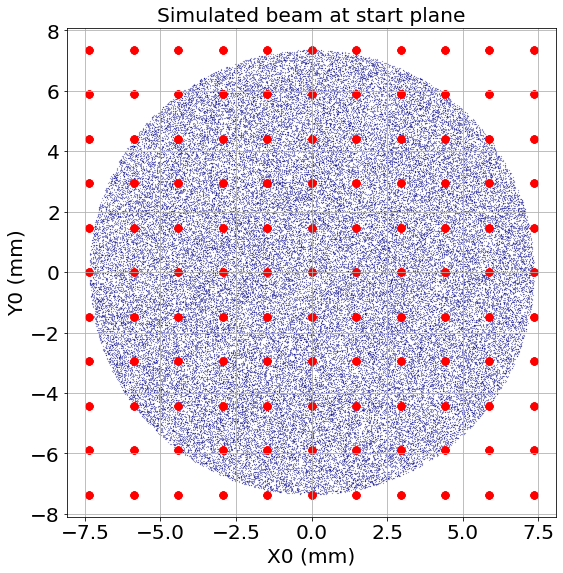

In [130]:
f, ax1 = plt.subplots(figsize=(9,9))
df.plot.scatter(x="X0", y="Y0",c="DarkBlue",marker=".",s=0.1,ax=ax1)
df_ref.plot.scatter(x="X0", y="Y0",c="red",marker="o",ax=ax1,s=50)
ax1.set(xlabel='X0 (mm)', ylabel='Y0 (mm)')
ax1.set_aspect("equal")
ax1.grid()
ax1.set_title("Simulated beam at start plane")

## Wavelength

In [131]:
WLSIM = np.array([0.0004,0.0006,0.0008,0.001])

## Scale

In [132]:
XSCALE=0.5
YSCALE=0.2

# Plot

## Dot plot

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


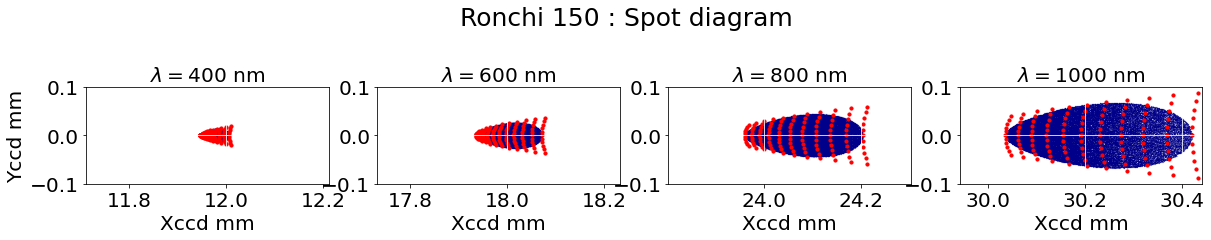

In [133]:
f, ax = plt.subplots(1,4,figsize=(20,4))

# loop on wavelength
for idx_WLSEL in np.arange(len(WLSIM)):
    

    wlsim=WLSIM[idx_WLSEL]
    wllabel="$\lambda = {:3.0f}$ nm".format(wlsim*mm_to_nm)
    
    # resampled beam
    if idx_WLSEL==0:
        Xccd=df["Xccd_400"].values
        Yccd=df["Yccd_400"].values
    elif idx_WLSEL==1:
        Xccd=df["Xccd_600"].values
        Yccd=df["Yccd_600"].values
    elif idx_WLSEL==2:
        Xccd=df["Xccd_800"].values
        Yccd=df["Yccd_800"].values
    elif idx_WLSEL==3:  
        Xccd=df["Xccd_1000"].values
        Yccd=df["Yccd_1000"].values
        
    # reference beam
    df_refwl=df_ref.loc[df_ref.wave==wlsim]
    Xccdref=df_refwl["X3"].values
    Yccdref=df_refwl["Y3"].values
    
    # central beam
    central_beam=df_refwl[(df_ref["X0"] == 0) & (df_ref["Y0"] == 0)]
    X3C=central_beam["X3"].values[0]
    Y3C=central_beam["Y3"].values[0]
    
    XMIN=X3C-XSCALE/2.
    XMAX=X3C+XSCALE/2

    YMIN=Y3C-YSCALE/2.
    YMAX=Y3C+YSCALE/2
    
   
    #NBINX=(Xccd.max()-Xccd.min())/(Det_xpic*micr_to_mm)
    #NBINY=(Yccd.max()-Yccd.min())/(Det_xpic*micr_to_mm)
    
    NBINX=XSCALE/(Det_xpic*micr_to_mm)
    NBINY=YSCALE/(Det_xpic*micr_to_mm)

    NBINX=int(max(NBINX,1))
    NBINY=int(max(NBINY,1))
    
    
    ax[idx_WLSEL].scatter(Xccd,Yccd,marker="." ,color="DarkBlue",s=0.05)
    ax[idx_WLSEL].scatter(Xccdref,Yccdref,marker="o" ,color="Red",s=10)
    ax[idx_WLSEL].set_xlim(XMIN,XMAX)
    ax[idx_WLSEL].set_ylim(YMIN,YMAX)
    ax[idx_WLSEL].set_aspect("equal")
    ax[idx_WLSEL].set_xlabel("Xccd mm")
    if idx_WLSEL==0:
        ax[idx_WLSEL].set_ylabel("Yccd mm")
    title= wllabel
    ax[idx_WLSEL].set_title(title)
    ax[idx_WLSEL].grid(b=True,color="white")
   
    
    
#f.tight_layout()
title=disperser_name + " : Spot diagram"
plt.suptitle(title,y=0.95,fontsize=25)

figname="PSFSIM_SPOT2D_"+disperser_tag+"_MULTIWL_v2.pdf"
plt.savefig(figname)
    
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


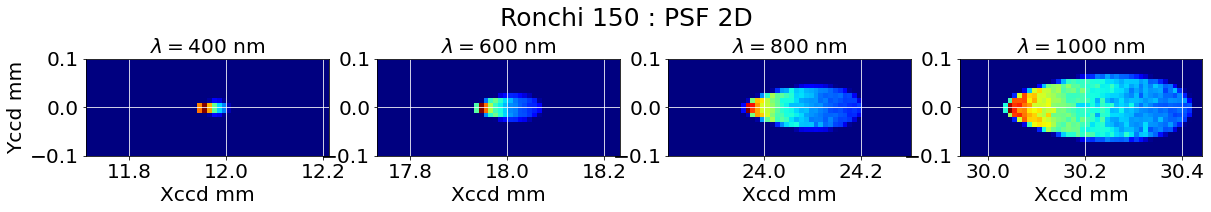

In [134]:
f, ax = plt.subplots(1,4,figsize=(20,4))

for idx_WLSEL in np.arange(len(WLSIM)):
    

    wlsim=WLSIM[idx_WLSEL]
    wllabel="$\lambda = {:3.0f}$ nm".format(wlsim*mm_to_nm)
    
    # resampled beam
    if idx_WLSEL==0:
        Xccd=df["Xccd_400"].values
        Yccd=df["Yccd_400"].values
    elif idx_WLSEL==1:
        Xccd=df["Xccd_600"].values
        Yccd=df["Yccd_600"].values
    elif idx_WLSEL==2:
        Xccd=df["Xccd_800"].values
        Yccd=df["Yccd_800"].values
    elif idx_WLSEL==3:  
        Xccd=df["Xccd_1000"].values
        Yccd=df["Yccd_1000"].values
        
    # reference beam
    df_refwl=df_ref.loc[df_ref.wave==wlsim]
    Xccdref=df_refwl["X3"].values
    Yccdref=df_refwl["Y3"].values
    
    # central beam
    central_beam=df_refwl[(df_ref["X0"] == 0) & (df_ref["Y0"] == 0)]
    X3C=central_beam["X3"].values[0]
    Y3C=central_beam["Y3"].values[0]
    
    XMIN=X3C-XSCALE/2.
    XMAX=X3C+XSCALE/2.

    YMIN=Y3C-YSCALE/2.
    YMAX=Y3C+YSCALE/2.
   
    #NBINX=(Xccd.max()-Xccd.min())/(Det_xpic*micr_to_mm)
    #NBINY=(Yccd.max()-Yccd.min())/(Det_xpic*micr_to_mm) 
    
    NBINX=XSCALE/(Det_xpic*micr_to_mm)
    NBINY=YSCALE/(Det_xpic*micr_to_mm) 

    NBINX=int(max(NBINX,1))
    NBINY=int(max(NBINY,1))
    
    ax[idx_WLSEL].hist2d(Xccd,Yccd,bins=(NBINX,NBINY),range=[[XMIN,XMAX],[YMIN,YMAX]],cmap=cm.get_cmap('jet'))
    #ax[idx_WLSEL].scatter(Xccdref,Yccdref,marker="o" ,color="k",s=10)
    ax[idx_WLSEL].set_aspect("equal")
    ax[idx_WLSEL].set_xlabel("Xccd mm")
    if idx_WLSEL==0:
        ax[idx_WLSEL].set_ylabel("Yccd mm")
    title= wllabel
    ax[idx_WLSEL].set_title(title)
    ax[idx_WLSEL].grid(b=True,color="white")
    
#f.tight_layout()
title=disperser_name + " : PSF 2D"
plt.suptitle(title,y=0.85,fontsize=25)
figname="PSFSIM_PSF2D_"+disperser_tag+"_MULTIWL_v2.pdf"
plt.savefig(figname)
      

# FWHM

In [135]:
def ComputeFWHM(values,nbins=50,thetitle="fwhm",thexlabel="X (mm)",flagplot=False,ax=None):
    """
    ComputeFWHM(values,nbins,flagplot)
    
    input arg :
       values : list of values
       nbins. : number of bins in the histogram
       flagplot : flag to plot the distribution
    """
    
    counts, bins =np.histogram(values,bins=nbins)
    
    # compute bin width
    binwidths=(np.roll(bins,-1)-bins)[:-1]
    binwidth=np.mean(binwidths)
    
    # find max
    idx_max=np.where(counts==counts.max())[0][0]
    count_max=counts[idx_max]
    counts_halfmax=count_max/2.
    
    # bins above half max
    topmost=np.where(counts>=counts_halfmax)[0]
    idx_min_fwhm=topmost[0]
    idx_max_fwhm=topmost[-1]
    
    # lower upper part
    min_fwhm=bins[idx_min_fwhm]+binwidth/2.
    max_fwhm=bins[idx_max_fwhm]+binwidth/2.
    
    #fwhm
    fwhm=max_fwhm-min_fwhm
    
    
    if flagplot:
        if ax==None:
            f, ax = plt.subplots(figsize=(10,5))
        
        ax.hist(bins[:-1]+binwidth/2., bins+binwidth/2., weights=counts,facecolor="red",density=False)
        ax.axhline(y=counts_halfmax)
        ax.axvline(x=min_fwhm,color="k")
        ax.axvline(x=max_fwhm,color="k")
        
        ax.grid()
        thetitle=thetitle+" = {:3.0f} $\mu m$".format(fwhm*1000)
        ax.set_title(thetitle)
        ax.set_xlabel(thexlabel)
        
    return fwhm
            

## Accurate histo

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


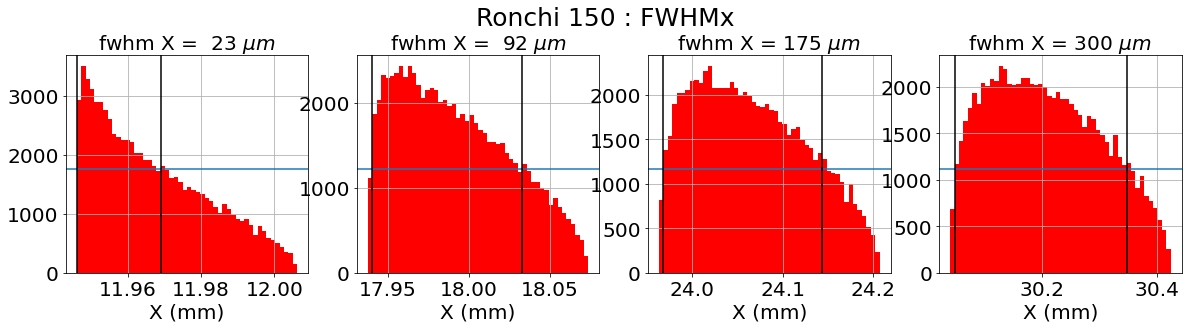

In [136]:
f, ax = plt.subplots(1,4,figsize=(20,4))
all_fwhmx=np.zeros(len(WLSIM))

for idx_WLSEL in np.arange(len(WLSIM)):
    

    wlsim=WLSIM[idx_WLSEL]
    wllabel="$\lambda = {:3.0f}$ nm".format(wlsim*mm_to_nm)
    
    # resampled beam
    if idx_WLSEL==0:
        Xccd=df["Xccd_400"].values
        Yccd=df["Yccd_400"].values
    elif idx_WLSEL==1:
        Xccd=df["Xccd_600"].values
        Yccd=df["Yccd_600"].values
    elif idx_WLSEL==2:
        Xccd=df["Xccd_800"].values
        Yccd=df["Yccd_800"].values
    elif idx_WLSEL==3:  
        Xccd=df["Xccd_1000"].values
        Yccd=df["Yccd_1000"].values
        
    # reference beam
    df_refwl=df_ref.loc[df_ref.wave==wlsim]
    Xccdref=df_refwl["X3"].values
    Yccdref=df_refwl["Y3"].values
    
    # central beam
    central_beam=df_refwl[(df_ref["X0"] == 0) & (df_ref["Y0"] == 0)]
    X3C=central_beam["X3"].values[0]
    Y3C=central_beam["Y3"].values[0]
    

    
    all_fwhmx[idx_WLSEL]=ComputeFWHM(Xccd,50,thetitle="fwhm X",thexlabel="X (mm)",flagplot=True,ax=ax[idx_WLSEL])
   
    
#f.tight_layout()
title=disperser_name + " : FWHMx"
plt.suptitle(title,y=1.05,fontsize=25)

figname="PSFSIM_FWHMX_"+disperser_tag+"_MULTIWL.pdf"
plt.savefig(figname)
      

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


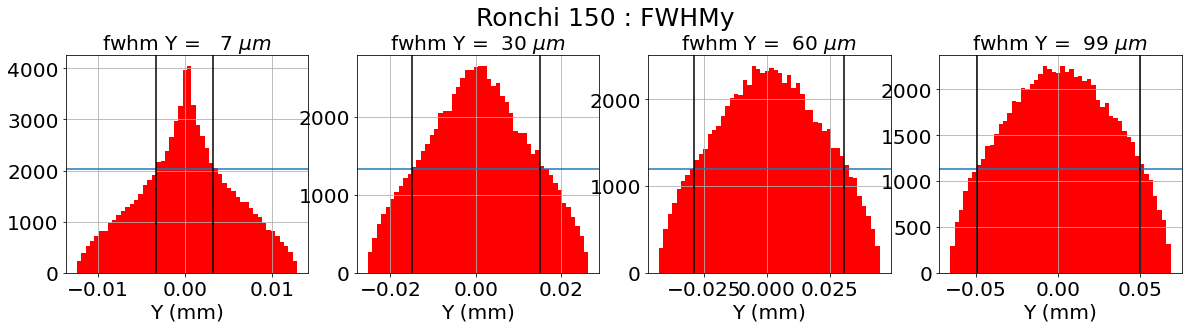

In [137]:
f, ax = plt.subplots(1,4,figsize=(20,4))

all_fwhmy=np.zeros(len(WLSIM))
for idx_WLSEL in np.arange(len(WLSIM)):
    

    wlsim=WLSIM[idx_WLSEL]
    wllabel="$\lambda = {:3.0f}$ nm".format(wlsim*mm_to_nm)
    
    # resampled beam
    if idx_WLSEL==0:
        Xccd=df["Xccd_400"].values
        Yccd=df["Yccd_400"].values
    elif idx_WLSEL==1:
        Xccd=df["Xccd_600"].values
        Yccd=df["Yccd_600"].values
    elif idx_WLSEL==2:
        Xccd=df["Xccd_800"].values
        Yccd=df["Yccd_800"].values
    elif idx_WLSEL==3:  
        Xccd=df["Xccd_1000"].values
        Yccd=df["Yccd_1000"].values
        
    # reference beam
    df_refwl=df_ref.loc[df_ref.wave==wlsim]
    Xccdref=df_refwl["X3"].values
    Yccdref=df_refwl["Y3"].values
    
    # central beam
    central_beam=df_refwl[(df_ref["X0"] == 0) & (df_ref["Y0"] == 0)]
    X3C=central_beam["X3"].values[0]
    Y3C=central_beam["Y3"].values[0]
    

    
    all_fwhmy[idx_WLSEL]=ComputeFWHM(Yccd,50,thetitle="fwhm Y",thexlabel="Y (mm)",flagplot=True,ax=ax[idx_WLSEL])
   
    
#f.tight_layout()
title=disperser_name + " : FWHMy"
plt.suptitle(title,y=1.05,fontsize=25)

figname="PSFSIM_FWHMY_"+disperser_tag+"_MULTIWL.pdf"
plt.savefig(figname)
      

## Histo in pixels

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


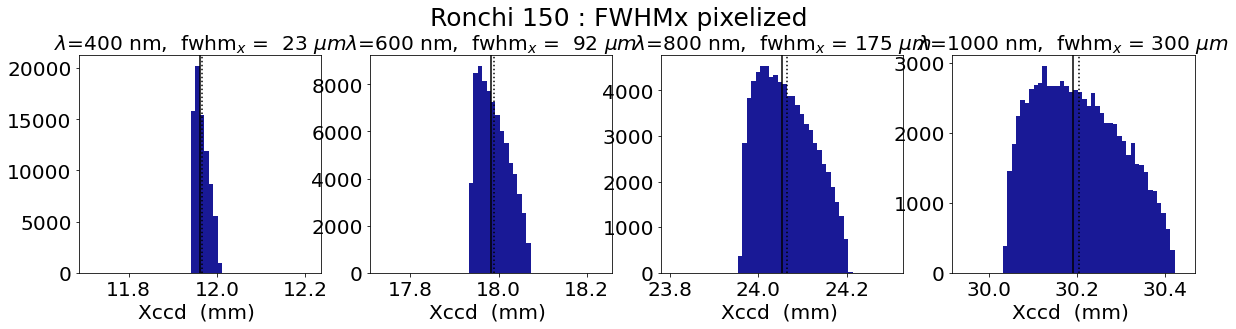

In [138]:
f, ax = plt.subplots(1,4,figsize=(20,4))

for idx_WLSEL in np.arange(len(WLSIM)):
    

    wlsim=WLSIM[idx_WLSEL]
    wllabel="$\lambda = {:3.0f}$ nm".format(wlsim*mm_to_nm)
    
    # resampled beam
    if idx_WLSEL==0:
        Xccd=df["Xccd_400"].values
        Yccd=df["Yccd_400"].values
    elif idx_WLSEL==1:
        Xccd=df["Xccd_600"].values
        Yccd=df["Yccd_600"].values
    elif idx_WLSEL==2:
        Xccd=df["Xccd_800"].values
        Yccd=df["Yccd_800"].values
    elif idx_WLSEL==3:  
        Xccd=df["Xccd_1000"].values
        Yccd=df["Yccd_1000"].values
        
    # reference beam
    df_refwl=df_ref.loc[df_ref.wave==wlsim]
    Xccdref=df_refwl["X3"].values
    Yccdref=df_refwl["Y3"].values
    
    # central beam
    central_beam=df_refwl[(df_ref["X0"] == 0) & (df_ref["Y0"] == 0)]
    X3C=central_beam["X3"].values[0]
    Y3C=central_beam["Y3"].values[0]
    
    XMIN=X3C-XSCALE/2.
    XMAX=X3C+XSCALE/2.

    YMIN=Y3C-YSCALE/2.
    YMAX=Y3C+YSCALE/2.
    
 
    fwhmx=ComputeFWHM(Xccd,50,thetitle="fwhm X",thexlabel="X (mm)",flagplot=False,ax=None)
   
   
    #NBINSX=int((Xccd.max()-Xccd.min())/(Det_xpic*micr_to_mm))
    #NBINSY=int((Yccd.max()-Yccd.min())/(Det_xpic*micr_to_mm)) 
    
    NBINSX=int(XSCALE/(Det_xpic*micr_to_mm))
    NBINSY=int(YSCALE/(Det_xpic*micr_to_mm)) 

    NBINSX=max(NBINSX,1)
    NBINSY=max(NBINSY,1)

    # compute the histogram
    h1=np.histogram(Xccd,bins=NBINSX,range=(XMIN,XMAX))
    h2=np.histogram(Yccd,bins=NBINSY,range=(YMIN,YMAX))

    counts1, bins1 = h1
    counts2, bins2 = h2


    # compute bin width
    # compute bin width
    binwidths1=(np.roll(bins1,-1)-bins1)[:-1]
    binwidth1=np.mean(binwidths1)

    binwidths2=(np.roll(bins2,-1)-bins2)[:-1]
    binwidth2=np.mean(binwidths2)

    # What to fit

    theX1=(bins1+binwidth1/2)[:-1]
    theY1=counts1

    theX2=(bins2+binwidth2/2)[:-1]
    theY2=counts2
    
    # in X
    
    ax[idx_WLSEL].hist(bins1[:-1], bins1, weights=counts1,facecolor="DarkBlue",density=False,alpha=0.9)
    ax[idx_WLSEL].set_xlabel("Xccd  (mm) ")
    title= "$\lambda$={:3.0f} nm,  fwhm$_x$ = {:3.0f} $\mu m$".format(wlsim*mm_to_nm,fwhmx*1000)
    ax[idx_WLSEL].set_title(title)
    ax[idx_WLSEL].axvline(x=X3C,color="k",label="central beam")
    ax[idx_WLSEL].axvline(x=Xccd.mean(),linestyle=":",color="k",label="average")
    #ax[idx_WLSEL].legend(fontsize=15)
      
    
#f.tight_layout()
title=disperser_name + " : FWHMx pixelized"
plt.suptitle(title,y=1.05,fontsize=25)

figname="PSFSIM_FWHMXPIX_"+disperser_tag+"_MULTIWL_v2.pdf"
plt.savefig(figname)
      

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


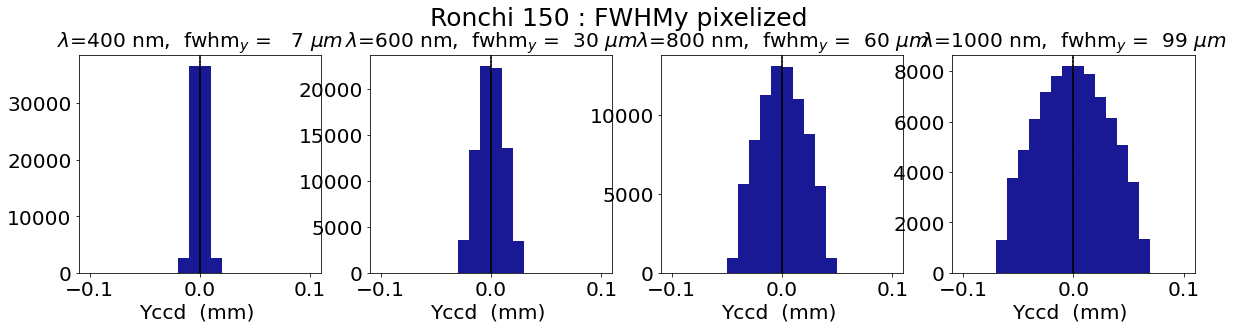

In [139]:
f, ax = plt.subplots(1,4,figsize=(20,4))

for idx_WLSEL in np.arange(len(WLSIM)):
    

    wlsim=WLSIM[idx_WLSEL]
    wllabel="$\lambda = {:3.0f}$ nm".format(wlsim*mm_to_nm)
    
    # resampled beam
    if idx_WLSEL==0:
        Xccd=df["Xccd_400"].values
        Yccd=df["Yccd_400"].values
    elif idx_WLSEL==1:
        Xccd=df["Xccd_600"].values
        Yccd=df["Yccd_600"].values
    elif idx_WLSEL==2:
        Xccd=df["Xccd_800"].values
        Yccd=df["Yccd_800"].values
    elif idx_WLSEL==3:  
        Xccd=df["Xccd_1000"].values
        Yccd=df["Yccd_1000"].values
        
    # reference beam
    df_refwl=df_ref.loc[df_ref.wave==wlsim]
    Xccdref=df_refwl["X3"].values
    Yccdref=df_refwl["Y3"].values
    
    # central beam
    central_beam=df_refwl[(df_ref["X0"] == 0) & (df_ref["Y0"] == 0)]
    X3C=central_beam["X3"].values[0]
    Y3C=central_beam["Y3"].values[0]
    
    XMIN=X3C-XSCALE/2.
    XMAX=X3C+XSCALE/2.

    YMIN=Y3C-YSCALE/2.
    YMAX=Y3C+YSCALE/2.
    
 
    fwhmy=ComputeFWHM(Yccd,50,thetitle="fwhm Y",thexlabel="Y (mm)",flagplot=False,ax=None)
   
   
    #NBINSX=int((Xccd.max()-Xccd.min())/(Det_xpic*micr_to_mm))
    #NBINSY=int((Yccd.max()-Yccd.min())/(Det_xpic*micr_to_mm)) 
    
    NBINSX=int(XSCALE/(Det_xpic*micr_to_mm))
    NBINSY=int(YSCALE/(Det_xpic*micr_to_mm)) 

    NBINSX=max(NBINSX,1)
    NBINSY=max(NBINSY,1)

    # compute the histogram
    #h1=np.histogram(Xccd,bins=NBINSX)
    #h2=np.histogram(Yccd,bins=NBINSY)
    h1=np.histogram(Xccd,bins=NBINSX,range=(XMIN,XMAX))
    h2=np.histogram(Yccd,bins=NBINSY,range=(YMIN,YMAX))

    counts1, bins1 = h1
    counts2, bins2 = h2


    # compute bin width
    # compute bin width
    binwidths1=(np.roll(bins1,-1)-bins1)[:-1]
    binwidth1=np.mean(binwidths1)

    binwidths2=(np.roll(bins2,-1)-bins2)[:-1]
    binwidth2=np.mean(binwidths2)

    # What to fit

    theX1=(bins1+binwidth1/2)[:-1]
    theY1=counts1

    theX2=(bins2+binwidth2/2)[:-1]
    theY2=counts2
    
    # in X
    
    ax[idx_WLSEL].hist(bins2[:-1], bins2, weights=counts2,facecolor="DarkBlue",density=False,alpha=0.9)
    ax[idx_WLSEL].set_xlabel("Yccd  (mm) ")
    title= "$\lambda$={:3.0f} nm,  fwhm$_y$ = {:3.0f} $\mu m$".format(wlsim*mm_to_nm,fwhmy*1000)
    ax[idx_WLSEL].set_title(title)
    ax[idx_WLSEL].axvline(x=Y3C,color="k",label="central beam")
    ax[idx_WLSEL].axvline(x=Yccd.mean(),linestyle=":",color="k",label="average")
    #ax[idx_WLSEL].legend(fontsize=15)
      
    
#f.tight_layout()
title=disperser_name + " : FWHMy pixelized"
plt.suptitle(title,y=1.05,fontsize=25)

figname="PSFSIM_FWHMYPIX_"+disperser_tag+"_MULTIWL_v2.pdf"
plt.savefig(figname)
      

# Output fwhm

In [140]:
outputfilename=disperser_tag+"_FWHMXY_MULTIWLOUT.csv"

In [141]:
all_fwhmx

array([0.02283699, 0.09240104, 0.17527028, 0.29972704])

In [142]:
all_fwhmy

array([0.00657741, 0.02990635, 0.0596677 , 0.09943257])

In [143]:
df_out=pd.DataFrame()
df_out["fwhmx"]=all_fwhmx
df_out["fwhmy"]=all_fwhmy

In [144]:
df_out.to_csv(outputfilename)

In [145]:
df_out

,fwhmx,fwhmy
0,0.022837,0.006577
1,0.092401,0.029906
2,0.175270,0.059668
3,0.299727,0.099433
